In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import tensorflow as tf

# Set plotting style
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages

In [2]:
# Define the medical feature names for better visualization
continuous_feature_names = [
    'Heart Rate',
    'Respiratory Rate', 
    'O2 saturation pulseoxymetry',
    'Inspired O2 Fraction',
    'Respiratory Rate (Set)'
]

# For heatmaps or tight spaces, use shorter names
continuous_feature_names_short = [
    'Heart Rate',
    'Resp Rate',
    'O2 sat',
    'Inspired O2',
    'Resp Rate (Set)'
]

discrete_feature_names = ['Medication/Intervention']

In [3]:
# Load real data
patinet_num = 16062
filename_postfix = '5_var'

# Load continuous data (vital signs)
continuous_x = np.loadtxt(f'data/real/mimic/vital_sign_24hrs_{filename_postfix}_mimiciv.txt')
continuous_x = continuous_x.reshape(patinet_num, 24, 5)

# Load discrete data (medications/interventions)
discrete_x = np.loadtxt(f'data/real/mimic/med_interv_24hrs_{filename_postfix}_mimiciv.txt')
discrete_x = discrete_x.reshape(patinet_num, 24, 1)

# Load static data (patient demographics)
statics_label = pd.read_csv(f'data/real/mimic/static_data_{filename_postfix}_mimiciv.csv')
statics_label = np.asarray(statics_label)[:, 0].reshape([-1, 1])

print("Real data shapes:")
print(f"Continuous: {continuous_x.shape}")
print(f"Discrete: {discrete_x.shape}")
print(f"Static labels: {statics_label.shape}")

# Load generated data
gen_data = np.load('data/fake/mimiciv_ipynb_36_60_initstd_04_lr_0001/epoch59/gen_data.npz')
# gen_data = np.load('data/fake/mimiciv_ipynb_50_64/epoch63/gen_data.npz')
c_gen_data = gen_data['c_gen_data']  # continuous data
d_gen_data = gen_data['d_gen_data']  # discrete data

print("\nGenerated data shapes:")
print(f"Continuous: {c_gen_data.shape}")
print(f"Discrete: {d_gen_data.shape}")

# Make sure we have the same number of samples for comparison
num_samples = min(len(continuous_x), len(c_gen_data))
continuous_x = continuous_x[:num_samples]
discrete_x = discrete_x[:num_samples]
c_gen_data = c_gen_data[:num_samples]
d_gen_data = d_gen_data[:num_samples]

print(f"\nUsing {num_samples} samples for evaluation")

Real data shapes:
Continuous: (16062, 24, 5)
Discrete: (16062, 24, 1)
Static labels: (16062, 1)

Generated data shapes:
Continuous: (15360, 24, 5)
Discrete: (15360, 24, 1)

Using 15360 samples for evaluation


In [4]:
# Function to calculate basic statistics
def calculate_stats(real, gen, name):
    print(f"\n--- {name} Statistics ---")
    
    # Reshape to 2D for easier analysis
    real_flat = real.reshape(-1, real.shape[-1])
    gen_flat = gen.reshape(-1, gen.shape[-1])
    
    # Calculate mean and std for each feature
    real_means = np.mean(real_flat, axis=0)
    real_stds = np.std(real_flat, axis=0)
    gen_means = np.mean(gen_flat, axis=0)
    gen_stds = np.std(gen_flat, axis=0)
    
    # Print statistics
    for i in range(real.shape[-1]):
        print(f"Feature {i}:")
        print(f"  Real: mean={real_means[i]:.4f}, std={real_stds[i]:.4f}")
        print(f"  Gen:  mean={gen_means[i]:.4f}, std={gen_stds[i]:.4f}")
        
    # KS test for distribution similarity
    for i in range(real.shape[-1]):
        ks_stat, p_value = stats.ks_2samp(real_flat[:, i], gen_flat[:, i])
        print(f"Feature {i} KS test: stat={ks_stat:.4f}, p-value={p_value:.4f}")
    
    return real_means, real_stds, gen_means, gen_stds

# Calculate statistics for continuous and discrete data
c_real_means, c_real_stds, c_gen_means, c_gen_stds = calculate_stats(
    continuous_x, c_gen_data, "Continuous")
d_real_means, d_real_stds, d_gen_means, d_gen_stds = calculate_stats(
    discrete_x, d_gen_data, "Discrete")


--- Continuous Statistics ---
Feature 0:
  Real: mean=0.3958, std=0.0791
  Gen:  mean=0.3975, std=0.0347
Feature 1:
  Real: mean=0.6401, std=0.1758
  Gen:  mean=0.6350, std=0.0181
Feature 2:
  Real: mean=0.9571, std=0.0578
  Gen:  mean=0.9662, std=0.0218
Feature 3:
  Real: mean=0.3348, std=0.1861
  Gen:  mean=0.3325, std=0.0342
Feature 4:
  Real: mean=0.3929, std=0.1254
  Gen:  mean=0.3880, std=0.0281
Feature 0 KS test: stat=0.2454, p-value=0.0000
Feature 1 KS test: stat=0.4386, p-value=0.0000
Feature 2 KS test: stat=0.2460, p-value=0.0000
Feature 3 KS test: stat=0.5131, p-value=0.0000
Feature 4 KS test: stat=0.3390, p-value=0.0000

--- Discrete Statistics ---
Feature 0:
  Real: mean=0.5536, std=0.4971
  Gen:  mean=0.6599, std=0.4737
Feature 0 KS test: stat=0.1063, p-value=0.0000


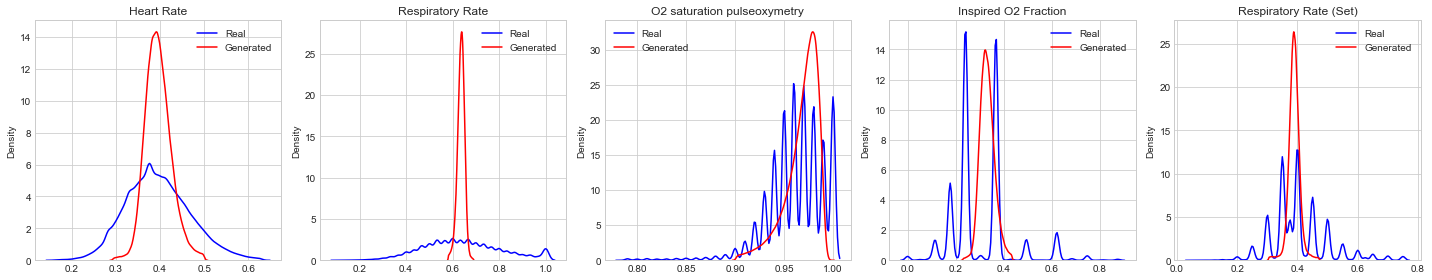

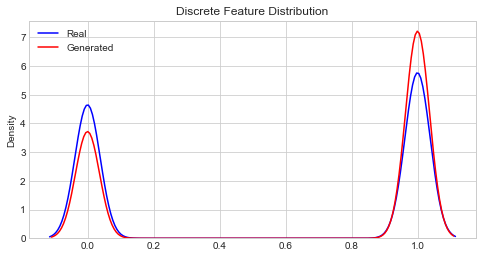

In [5]:
# Update the distribution visualization for continuous features
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, feature_name in enumerate(continuous_feature_names):
    real_data = continuous_x[:, :, i].flatten()
    gen_data = c_gen_data[:, :, i].flatten()
    
    # Remove outliers for better visualization
    real_data = real_data[np.abs(stats.zscore(real_data)) < 3]
    gen_data = gen_data[np.abs(stats.zscore(gen_data)) < 3]
    
    sns.kdeplot(real_data, ax=axes[i], label='Real', color='blue')
    sns.kdeplot(gen_data, ax=axes[i], label='Generated', color='red')
    axes[i].set_title(f'{feature_name}')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Visualize distributions for discrete features
plt.figure(figsize=(8, 4))
real_data = discrete_x.flatten()
gen_data = d_gen_data.flatten()
sns.kdeplot(real_data, label='Real', color='blue')
sns.kdeplot(gen_data, label='Generated', color='red')
plt.title('Discrete Feature Distribution')
plt.legend()
plt.show()

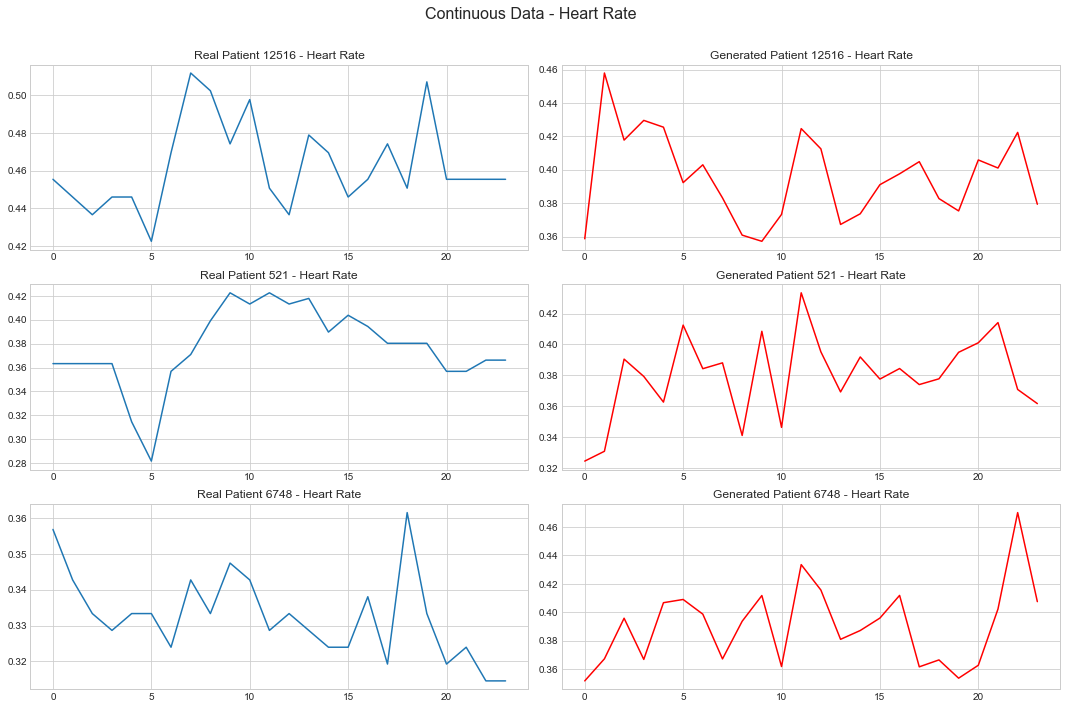

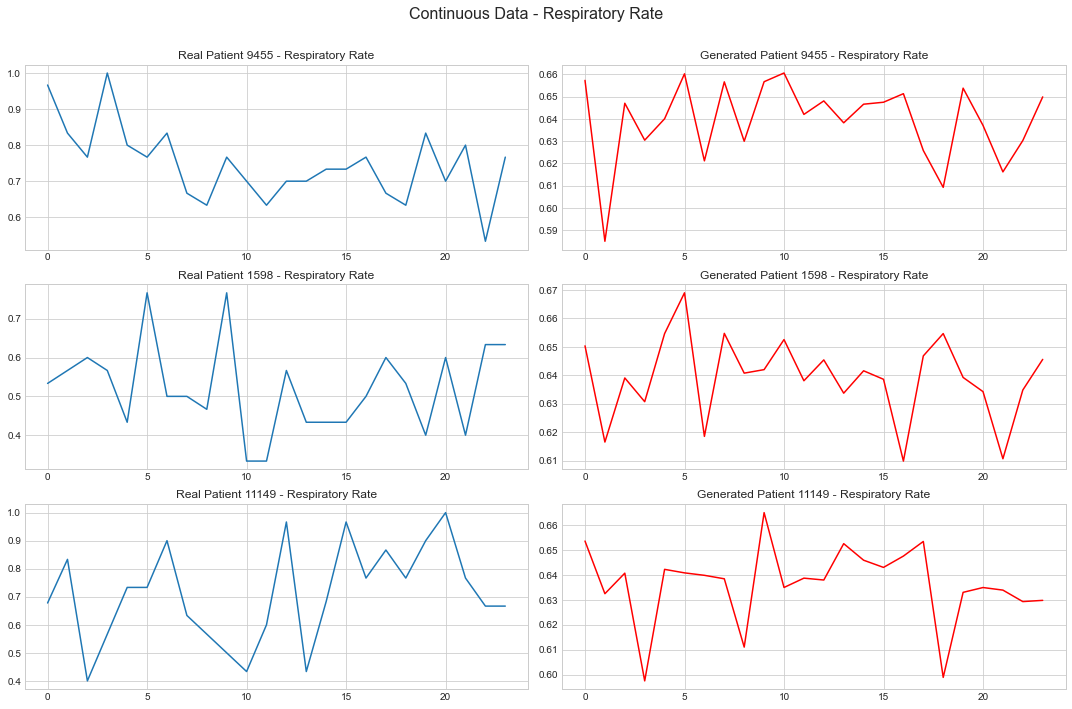

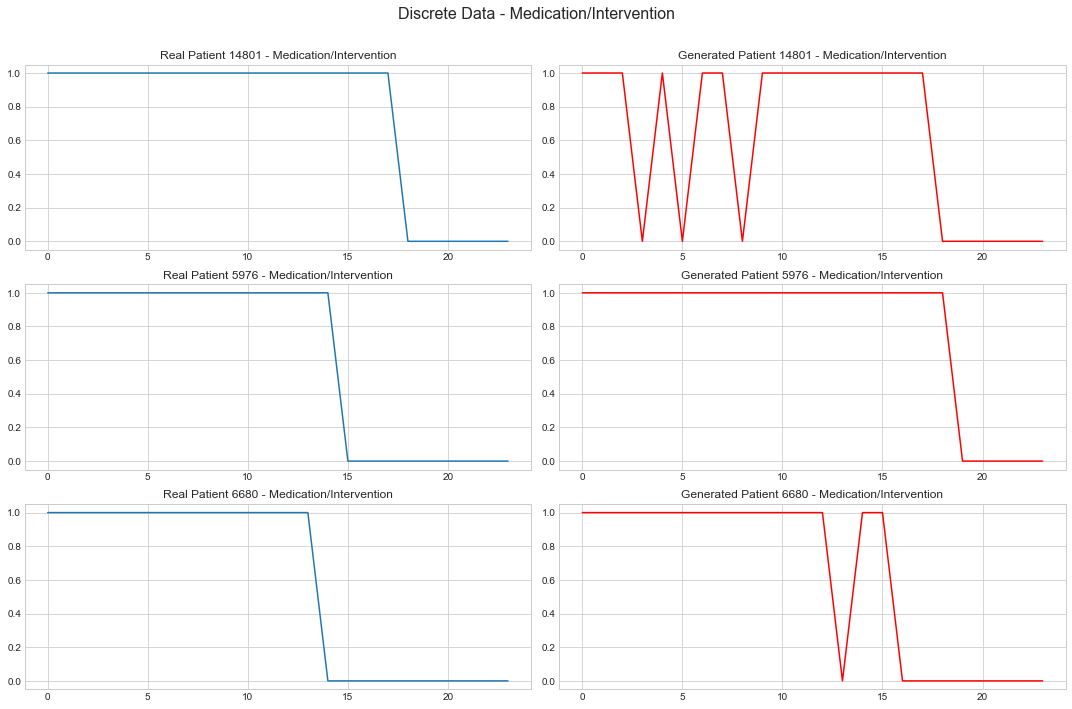

In [6]:
# Update the time series visualization
def plot_time_series(real, gen, name, num_patients=3, features=None):
    if features is None:
        features = range(real.shape[2])
    
    feature_names = continuous_feature_names if name == 'Continuous' else discrete_feature_names
    
    for j, feature_idx in enumerate(features):
        plt.figure(figsize=(15, 10))
        for i in range(num_patients):
            # Random patient index
            idx = np.random.randint(0, len(real))
            
            plt.subplot(num_patients, 2, i*2+1)
            plt.plot(real[idx, :, feature_idx])
            plt.title(f'Real Patient {idx} - {feature_names[feature_idx]}')
            
            plt.subplot(num_patients, 2, i*2+2)
            plt.plot(gen[idx, :, feature_idx], color='red')
            plt.title(f'Generated Patient {idx} - {feature_names[feature_idx]}')
            
        plt.tight_layout()
        plt.suptitle(f'{name} Data - {feature_names[feature_idx]}', fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.show()

# Plot some time series
plot_time_series(continuous_x, c_gen_data, 'Continuous', num_patients=3, features=[0, 1])
plot_time_series(discrete_x, d_gen_data, 'Discrete', num_patients=3)

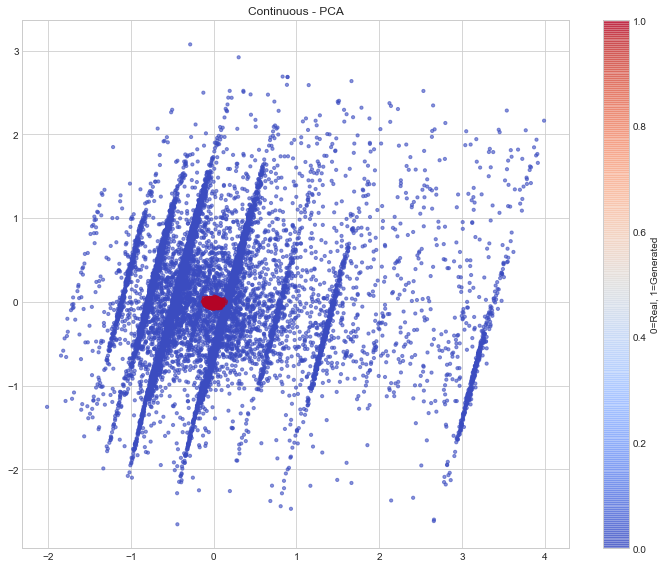

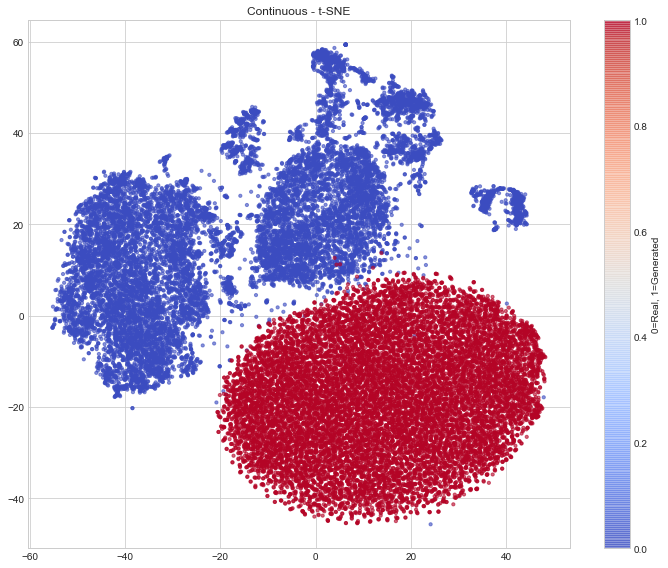

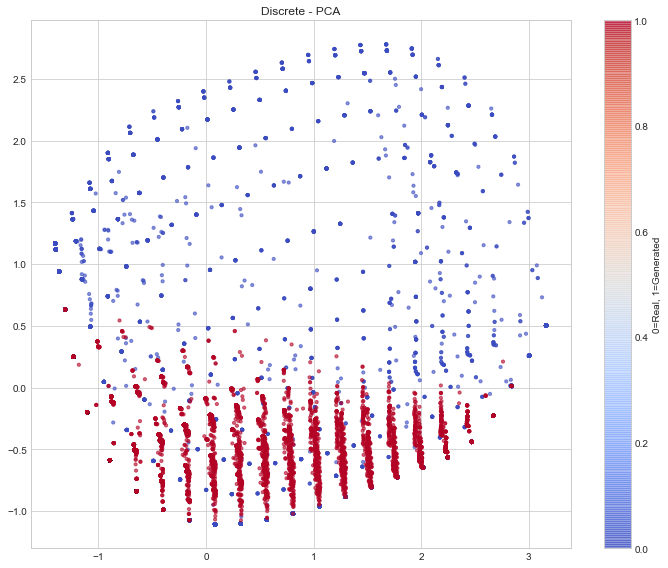

In [7]:
# Use PCA and t-SNE to visualize high-dimensional distributions
def dim_reduction_plot(real, gen, name, method='pca'):
    # Reshape to 2D: (patients, timesteps*features)
    real_flat = real.reshape(real.shape[0], -1)
    gen_flat = gen.reshape(gen.shape[0], -1)
    
    # Combine real and generated data
    combined = np.vstack([real_flat, gen_flat])
    
    # Labels (0 for real, 1 for generated)
    labels = np.concatenate([np.zeros(len(real_flat)), np.ones(len(gen_flat))])
    
    # Dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=2)
        title = f'{name} - PCA'
    else:
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
        title = f'{name} - t-SNE'
    
    # Apply dimensionality reduction
    reduced = reducer.fit_transform(combined)
    
    # Visualize
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, 
               cmap='coolwarm', alpha=0.6, s=10)
    plt.colorbar(scatter, label='0=Real, 1=Generated')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# PCA and t-SNE visualization
dim_reduction_plot(continuous_x, c_gen_data, 'Continuous', method='pca')
dim_reduction_plot(continuous_x, c_gen_data, 'Continuous', method='tsne')
dim_reduction_plot(discrete_x, d_gen_data, 'Discrete', method='pca')

W0227 10:24:09.310033  3960 deprecation.py:506] From c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0227 10:24:09.391267  3960 deprecation.py:323] From c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 24576 samples, validate on 6144 samples
Epoch 1/10
24576/24576 [==============================] - 0s 12us/sample - loss: 0.3880 - acc: 0.8477 - val_loss: 0.0811 - val_acc: 0.9863
Epoch 2/10
24576/24576 [==============================] - 0s 9us/sample - loss: 0.0615 - acc: 0.9885 - val_loss: 0.0144 - val_acc: 0.9993
Epoch 3/10
24576/24576 [==============================] - 0s 9us/sample - loss: 0.0285 - acc: 0.9938 - val_loss: 0.0083 - val_acc: 0.9993
Epoch 4/10
24576/24576 [==============================] - 0s 9us/sample - loss: 0.0242 - acc: 0.9936 - val_loss: 0.0076 - val_acc: 0.9990
Epoch 5/10
24576/24576 [==============================] - 0s 9us/sample - loss: 0.0182 - acc: 0.9957 - val_loss: 0.0039 - val_acc: 0.9998
Epoch 6/10
24576/24576 [==============================] - 0s 9us/sample - loss: 0.0135 - acc: 0.9967 - val_loss: 0.0054 - val_acc: 0.9998
Epoch 7/10
24576/24576 [==============================] - 0s 9us/sample - loss: 0.0244 - acc: 0.9927 - val_loss: 0.0057 - 

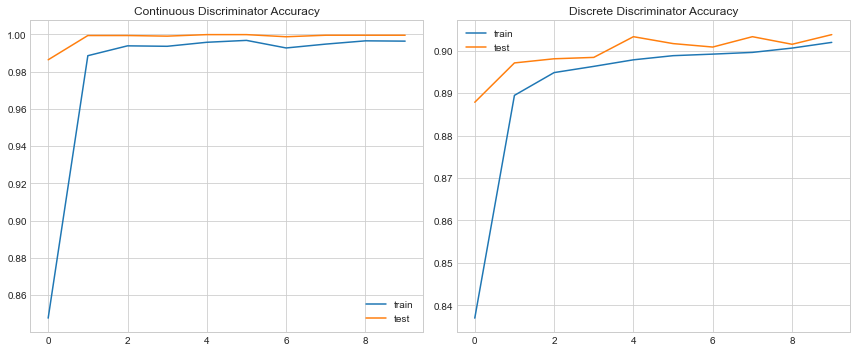

In [8]:
# Train a model to distinguish real from generated data
def train_discriminator(real, gen):
    # Prepare data
    real_flat = real.reshape(real.shape[0], -1)
    gen_flat = gen.reshape(gen.shape[0], -1)
    
    # Combine and create labels
    X = np.vstack([real_flat, gen_flat])
    y = np.concatenate([np.zeros(len(real_flat)), np.ones(len(gen_flat))])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    # Create a simple neural network discriminator
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])  # Use 'acc' instead of 'accuracy' for TF 1.x
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        validation_data=(X_test, y_test),
        verbose=1,  # Changed to 1 to see training progress
        batch_size=128
    )
    
    # Evaluate model
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    apr = average_precision_score(y_test, y_pred)
    
    return auc, apr, history

# Evaluate discriminative performance
c_auc, c_apr, c_history = train_discriminator(continuous_x, c_gen_data)
print(f"Continuous data - AUC: {c_auc:.4f}, APR: {c_apr:.4f}")

d_auc, d_apr, d_history = train_discriminator(discrete_x, d_gen_data)
print(f"Discrete data - AUC: {d_auc:.4f}, APR: {d_apr:.4f}")

# Plot training history - using 'acc' instead of 'accuracy' for TF 1.x
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(c_history.history['acc'], label='train')  # Changed to 'acc'
plt.plot(c_history.history['val_acc'], label='test')  # Changed to 'val_acc'
plt.title('Continuous Discriminator Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(d_history.history['acc'], label='train')  # Changed to 'acc'
plt.plot(d_history.history['val_acc'], label='test')  # Changed to 'val_acc'
plt.title('Discrete Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

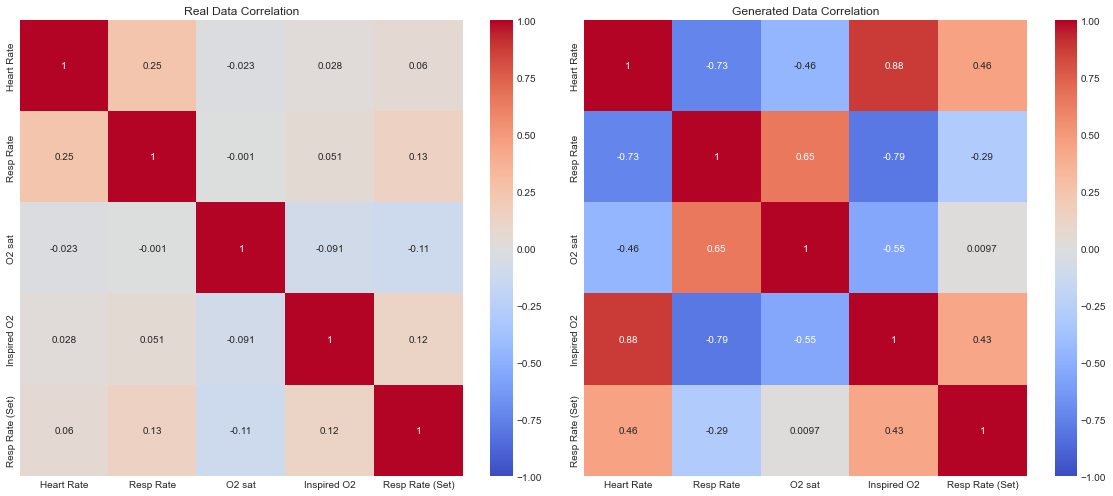

Correlation difference (L1 norm): 10.94574496993961


In [9]:
# Update correlation analysis with feature names
def correlation_analysis(real, gen):
    # Reshape to 2D: (patients*timesteps, features)
    real_flat = real.reshape(-1, real.shape[-1])
    gen_flat = gen.reshape(-1, gen.shape[-1])
    
    # Calculate correlation matrices
    real_corr = np.corrcoef(real_flat.T)
    gen_corr = np.corrcoef(gen_flat.T)
    
    # Plot correlation matrices
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    sns.heatmap(real_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0],
                xticklabels=continuous_feature_names_short, 
                yticklabels=continuous_feature_names_short)
    axes[0].set_title('Real Data Correlation')
    
    sns.heatmap(gen_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1],
                xticklabels=continuous_feature_names_short, 
                yticklabels=continuous_feature_names_short)
    axes[1].set_title('Generated Data Correlation')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate difference in correlation matrices
    corr_diff = np.abs(real_corr - gen_corr)
    print("Correlation difference (L1 norm):", np.sum(corr_diff))
    
    return real_corr, gen_corr, corr_diff

# Only run correlation analysis on continuous data (multiple features)
if continuous_x.shape[-1] > 1:
    c_real_corr, c_gen_corr, c_corr_diff = correlation_analysis(continuous_x, c_gen_data)

c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in tru

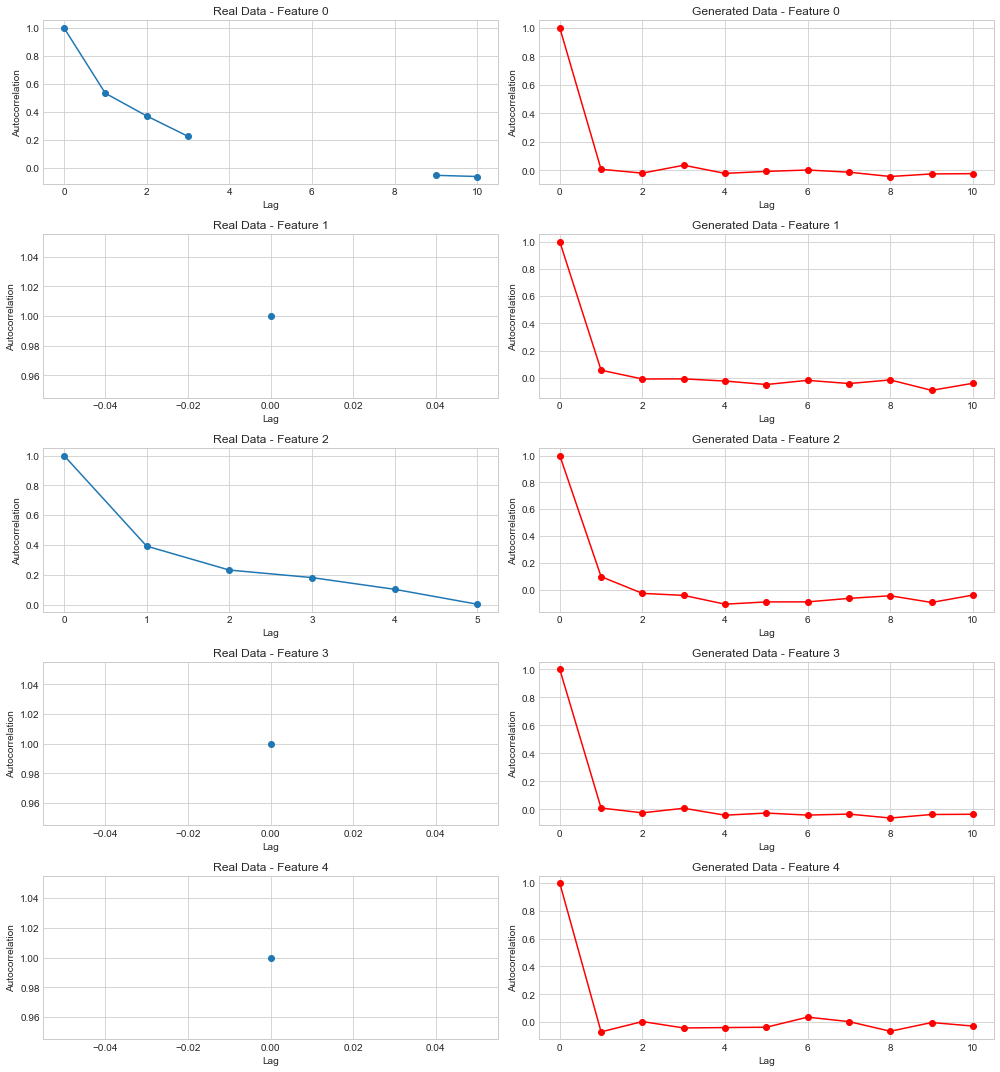

In [10]:
# Calculate autocorrelation for time series
def autocorr_analysis(real, gen, max_lag=10):
    n_features = real.shape[2]
    
    fig, axes = plt.subplots(n_features, 2, figsize=(14, 3*n_features))
    
    for feature in range(n_features):
        real_acorrs = []
        gen_acorrs = []
        
        # Calculate autocorrelation for each patient, then average
        for patient_idx in range(min(100, real.shape[0])):
            real_ts = real[patient_idx, :, feature]
            gen_ts = gen[patient_idx, :, feature]
            
            # Calculate autocorrelation for real data
            real_acorr = [1.0]  # Lag 0 autocorrelation is always 1
            for lag in range(1, max_lag+1):
                real_acorr.append(np.corrcoef(real_ts[lag:], real_ts[:-lag])[0, 1])
            real_acorrs.append(real_acorr)
            
            # Calculate autocorrelation for generated data
            gen_acorr = [1.0]
            for lag in range(1, max_lag+1):
                gen_acorr.append(np.corrcoef(gen_ts[lag:], gen_ts[:-lag])[0, 1])
            gen_acorrs.append(gen_acorr)
        
        # Average across patients
        real_acorr_avg = np.mean(real_acorrs, axis=0)
        gen_acorr_avg = np.mean(gen_acorrs, axis=0)
        
        # Plot
        if n_features == 1:
            ax1, ax2 = axes
        else:
            ax1, ax2 = axes[feature]
            
        ax1.plot(range(max_lag+1), real_acorr_avg, marker='o')
        ax1.set_title(f'Real Data - Feature {feature}')
        ax1.set_xlabel('Lag')
        ax1.set_ylabel('Autocorrelation')
        
        ax2.plot(range(max_lag+1), gen_acorr_avg, marker='o', color='red')
        ax2.set_title(f'Generated Data - Feature {feature}')
        ax2.set_xlabel('Lag')
        ax2.set_ylabel('Autocorrelation')
    
    plt.tight_layout()
    plt.show()

# Calculate autocorrelation
autocorr_analysis(continuous_x, c_gen_data, max_lag=10)

In [17]:
print(continuous_x.shape)
print(c_gen_data.shape)
continuous_x

(15360, 24, 5)
(15360, 24, 5)


array([[[0.49295775, 0.36666667, 0.93      , 0.36708861, 0.35      ],
        [0.5399061 , 0.36666667, 0.92      , 0.36708861, 0.35      ],
        [0.49765258, 0.33333333, 0.95      , 0.36708861, 0.35      ],
        ...,
        [0.44131455, 0.36666667, 1.        , 0.24050633, 0.35      ],
        [0.45539906, 0.46666667, 1.        , 0.24050633, 0.35      ],
        [0.45539906, 0.46666667, 1.        , 0.24050633, 0.35      ]],

       [[0.37558685, 0.5111    , 1.        , 0.36708861, 0.375     ],
        [0.37558685, 0.26666667, 1.        , 0.24050633, 0.375     ],
        [0.37558685, 0.6       , 0.98      , 0.24050633, 0.375     ],
        ...,
        [0.30516432, 0.56666667, 1.        , 0.24050633, 0.375     ],
        [0.30516432, 0.56666667, 1.        , 0.24050633, 0.375     ],
        [0.30516432, 0.56666667, 1.        , 0.24050633, 0.375     ]],

       [[0.37089202, 0.46666667, 1.        , 1.        , 0.3       ],
        [0.37558685, 0.36666667, 1.        , 0.62025316, 0.3

In [18]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from scipy.stats import median_abs_deviation

def calculate_mmd(real_data, generated_data, kernel='rbf', feature_wise=True, 
                  bandwidth_method='median', max_samples=2000):
    """
    Calculate Maximum Mean Discrepancy between real and generated data.
    
    Parameters:
    -----------
    real_data : numpy.ndarray
        Real data with shape (n_samples, n_timesteps, n_features)
    generated_data : numpy.ndarray
        Generated data with shape (n_samples, n_timesteps, n_features)
    kernel : str, default='rbf'
        Kernel type ('rbf' or 'linear')
    feature_wise : bool, default=True
        Whether to calculate MMD for each feature separately
    bandwidth_method : str, default='median'
        Method to determine bandwidth ('median', 'scott', or float value)
    max_samples : int, default=2000
        Maximum number of samples to use (to prevent memory issues)
        
    Returns:
    --------
    dict : Dictionary containing overall MMD and feature-wise MMD if requested
    """
    # Subsample if data is too large (for memory efficiency)
    if real_data.shape[0] > max_samples:
        np.random.seed(42)  # For reproducibility
        idx_real = np.random.choice(real_data.shape[0], max_samples, replace=False)
        real_data = real_data[idx_real]
    
    if generated_data.shape[0] > max_samples:
        np.random.seed(43)  # Different seed for generated data
        idx_gen = np.random.choice(generated_data.shape[0], max_samples, replace=False)
        generated_data = generated_data[idx_gen]
    
    # Extract dimensions
    n_real = real_data.shape[0]
    n_gen = generated_data.shape[0]
    n_features = real_data.shape[2]
    
    # Reshape to 2D: (samples, timesteps*features)
    real_flat = real_data.reshape(n_real, -1)
    gen_flat = generated_data.reshape(n_gen, -1)
    
    # Calculate overall MMD
    results = {}
    
    # Determine bandwidth (sigma)
    if isinstance(bandwidth_method, float):
        sigma = bandwidth_method
    elif bandwidth_method == 'median':
        # Use median heuristic
        combined = np.vstack([real_flat, gen_flat])
        pairwise_dists = np.median(np.square(combined[:, np.newaxis, :] - combined[np.newaxis, :, :]).sum(axis=2))
        sigma = np.sqrt(pairwise_dists / 2)
    elif bandwidth_method == 'scott':
        # Scott's rule
        combined = np.vstack([real_flat, gen_flat])
        sigma = np.power(combined.shape[0], -1.0/(combined.shape[1]+4)) * np.std(combined)
    else:
        sigma = 1.0  # Default
    
    # Calculate kernel matrices
    gamma = 1.0 / (2 * sigma**2)
    K_XX = rbf_kernel(real_flat, real_flat, gamma=gamma)
    K_YY = rbf_kernel(gen_flat, gen_flat, gamma=gamma)
    K_XY = rbf_kernel(real_flat, gen_flat, gamma=gamma)
    
    # Calculate MMD
    mmd = (np.sum(K_XX) - np.trace(K_XX)) / (n_real * (n_real - 1))
    mmd += (np.sum(K_YY) - np.trace(K_YY)) / (n_gen * (n_gen - 1))
    mmd -= 2 * np.sum(K_XY) / (n_real * n_gen)
    
    results['overall_mmd'] = np.sqrt(max(mmd, 0))  # Take sqrt for distance metric
    
    # Calculate per-feature MMD if requested
    if feature_wise:
        feature_mmds = {}
        for i in range(n_features):
            # Extract single feature across all timesteps
            real_feature = real_data[:, :, i].reshape(n_real, -1)
            gen_feature = generated_data[:, :, i].reshape(n_gen, -1)
            
            # Determine bandwidth for this feature
            if bandwidth_method == 'median':
                combined = np.vstack([real_feature, gen_feature])
                pairwise_dists = np.median(np.square(combined[:, np.newaxis, :] - combined[np.newaxis, :, :]).sum(axis=2))
                feature_sigma = np.sqrt(pairwise_dists / 2)
            else:
                feature_sigma = sigma
            
            # Calculate kernel matrices
            gamma = 1.0 / (2 * feature_sigma**2)
            K_XX = rbf_kernel(real_feature, real_feature, gamma=gamma)
            K_YY = rbf_kernel(gen_feature, gen_feature, gamma=gamma)
            K_XY = rbf_kernel(real_feature, gen_feature, gamma=gamma)
            
            # Calculate MMD
            feature_mmd = (np.sum(K_XX) - np.trace(K_XX)) / (n_real * (n_real - 1))
            feature_mmd += (np.sum(K_YY) - np.trace(K_YY)) / (n_gen * (n_gen - 1))
            feature_mmd -= 2 * np.sum(K_XY) / (n_real * n_gen)
            
            feature_mmds[f'feature_{i}_mmd'] = np.sqrt(max(feature_mmd, 0))
        
        results['feature_wise_mmd'] = feature_mmds
    
    return results

In [19]:
# Calculate MMD between real and generated data
mmd_results = calculate_mmd(continuous_x, c_gen_data, 
                           bandwidth_method='median', 
                           feature_wise=True,
                           max_samples=2000)  # Using 2000 samples for efficiency

# Print overall MMD
print(f"Overall MMD: {mmd_results['overall_mmd']:.6f}")

# Print feature-wise MMD scores
if 'feature_wise_mmd' in mmd_results:
    print("\nFeature-wise MMD scores:")
    for i, feature_name in enumerate(continuous_feature_names):
        feature_mmd = mmd_results['feature_wise_mmd'][f'feature_{i}_mmd']
        print(f"{feature_name}: {feature_mmd:.6f}")

Overall MMD: 0.630750

Feature-wise MMD scores:
Heart Rate: 0.512684
Respiratory Rate: 0.669406
O2 saturation pulseoxymetry: 0.357373
Inspired O2 Fraction: 0.640500
Respiratory Rate (Set): 0.583957


In [12]:
# Create a summary table of key metrics
metrics_summary = {
    'Metric': [
        'KS Test p-value (avg)',
        'Distribution Similarity (visual)',
        'Discriminator AUC',
        'Correlation Structure',
        'Autocorrelation Structure'
    ],
    'Continuous Data': [
        np.mean([stats.ks_2samp(
            continuous_x[:, :, i].flatten(), 
            c_gen_data[:, :, i].flatten())[1] for i in range(continuous_x.shape[2])]),
        'See plots',
        c_auc,
        np.sum(np.abs(c_real_corr - c_gen_corr)) if continuous_x.shape[-1] > 1 else 'N/A',
        'See plots'
    ],
    'Discrete Data': [
        stats.ks_2samp(discrete_x.flatten(), d_gen_data.flatten())[1],
        'See plots',
        d_auc,
        'N/A',
        'See plots'
    ]
}
# Add MMD to the summary metrics
if 'metrics_summary' in locals():
    metrics_summary['Metric'].append('Maximum Mean Discrepancy (MMD)')
    metrics_summary['Continuous Data'].append(c_mmd if 'c_mmd' in locals() else 'Error')
    metrics_summary['Discrete Data'].append(d_mmd if 'd_mmd' in locals() else 'Error')

# Convert to DataFrame for better display
metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df)

                             Metric Continuous Data Discrete Data
0             KS Test p-value (avg)               0             0
1  Distribution Similarity (visual)       See plots     See plots
2                 Discriminator AUC               1      0.962067
3             Correlation Structure         10.9457           N/A
4         Autocorrelation Structure       See plots     See plots
5    Maximum Mean Discrepancy (MMD)           Error         Error


<Figure size 720x432 with 0 Axes>

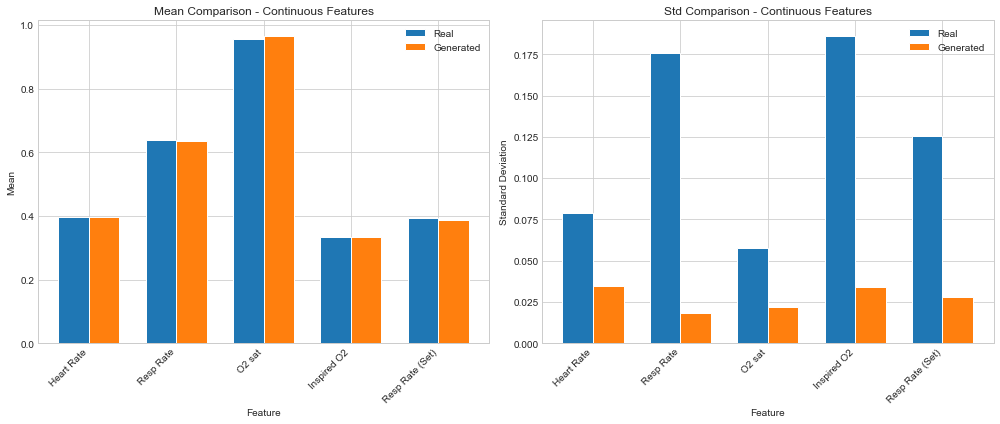

In [13]:
# Save results to CSV
metrics_df.to_csv('evaluation_results.csv', index=False)

# Update the final visualization with proper feature names
plt.figure(figsize=(10, 6))
# Plot mean and std comparison
x = np.arange(len(continuous_feature_names))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Mean comparison
ax1.bar(x - width/2, c_real_means, width, label='Real')
ax1.bar(x + width/2, c_gen_means, width, label='Generated')
ax1.set_xlabel('Feature')
ax1.set_ylabel('Mean')
ax1.set_title('Mean Comparison - Continuous Features')
ax1.set_xticks(x)
ax1.set_xticklabels(continuous_feature_names_short, rotation=45, ha='right')
ax1.legend()

# Std comparison
ax2.bar(x - width/2, c_real_stds, width, label='Real')
ax2.bar(x + width/2, c_gen_stds, width, label='Generated')
ax2.set_xlabel('Feature')
ax2.set_ylabel('Standard Deviation')
ax2.set_title('Std Comparison - Continuous Features')
ax2.set_xticks(x)
ax2.set_xticklabels(continuous_feature_names_short, rotation=45, ha='right')
ax2.legend()

plt.tight_layout()
plt.savefig('continuous_stats_comparison.png')
plt.show()